In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "digit-recognizer"

loading and preprocessing the data

In [2]:
library(keras)
library(readr)

train <- read_csv("/kaggle/input/digit-recognizer/train.csv")
test  <- read_csv("/kaggle/input/digit-recognizer/test.csv")

Rows: 42000 Columns: 785


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (785): label, pixel0, pixel1, pixel2, pixel3, pixel4, pixel5, pixel6, pi...



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 28000 Columns: 784


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (784): pixel0, pixel1, pixel2, pixel3, pixel4, pixel5, pixel6, pixel7, p...



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Normalize and reshape
X <- as.matrix(train[, -1]) / 255
y <- to_categorical(train$label, num_classes = 10)


In [4]:
# Convert to list of 28x28x1 arrays
X_list <- lapply(1:nrow(X), function(i) array(X[i, ], dim = c(28, 28, 1)))


Splitting

In [5]:
# Split
set.seed(123)
indices <- sample(1:length(X_list), size = 0.9 * length(X_list))
library(abind)

X_train <- abind(X_list[indices], along = 0)
X_val   <- abind(X_list[-indices], along = 0)
y_train <- y[indices, ]
y_val   <- y[-indices, ]

Create an Enhanced CNN Model

In [6]:
model <- keras_model_sequential() %>%
  layer_conv_2d(32, kernel_size = c(3,3), activation = "relu", input_shape = c(28,28,1)) %>%
  layer_batch_normalization() %>%
  layer_conv_2d(32, kernel_size = c(3,3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_dropout(0.25) %>%

  layer_conv_2d(64, kernel_size = c(3,3), activation = "relu") %>%
  layer_batch_normalization() %>%
  layer_conv_2d(64, kernel_size = c(3,3), activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  layer_dropout(0.25) %>%

  layer_flatten() %>%
  layer_dense(256, activation = "relu") %>%
  layer_dropout(0.5) %>%
  layer_dense(10, activation = "softmax")


Compile with Learning Rate Adjustment

In [7]:
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adam(learning_rate = 0.001),
  metrics = "accuracy"
)


Add Early Stopping & Train

In [8]:
early_stop <- callback_early_stopping(monitor = "val_accuracy", patience = 5, restore_best_weights = TRUE)

history <- model %>% fit(
  X_train, y_train,
  epochs = 50,
  batch_size = 128,
  validation_data = list(X_val, y_val),
  callbacks = list(early_stop)
)


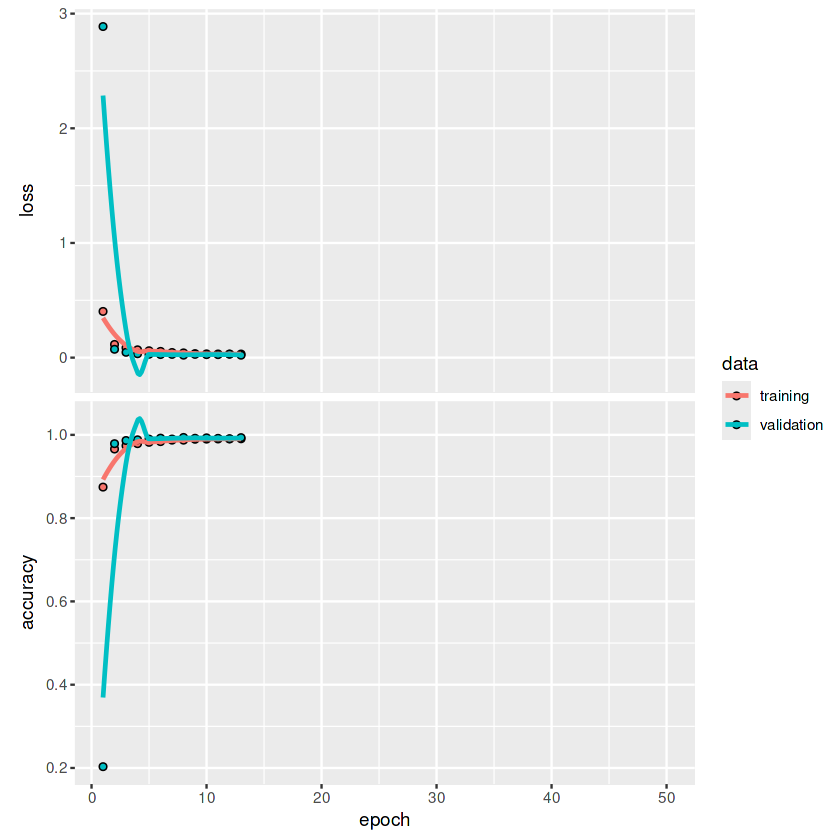

In [9]:
plot(history)


Predicting & Submitting

In [10]:
X_test <- as.matrix(test) / 255
X_test <- array(X_test, dim = c(nrow(X_test), 28, 28, 1))

predictions <- model %>% predict(X_test)
predicted_labels <- apply(predictions, 1, which.max) - 1

submission <- data.frame(ImageId = 1:nrow(test), Label = predicted_labels)
write.csv(submission, "submission.csv", row.names = FALSE)
